<table class="sprawko-header" style="width: 90%; border-style: hidden; font-size: 22px; line-height: 1.2em;">
<tr style="border-style: hidden;">
    <td style="width: 50%; border-style: hidden;">Informatyka, studia dzienne, II st.</td>
    <td style="width: 50%; text-align: right; border-style: hidden;">semestr II</td>
</tr>
<tr style="border-style: hidden;">
    <td style="width: 50%; border-style: hidden;">
        <b>Współczesne technologie programowania</b><br> Prowadzący: Kamil Stokfiszewski
    </td>
    <td style="width: 50%; text-align: right; border-style: hidden;">
        2016/2017<br> wtorek, 10:15
    </td>
</tr>
<tr style="border-style: hidden;">
    <td colspan="2">
        <ul style="width: 100%; text-align: center;  list-style: none;">
            <li>Daniel Pęczek 207585</li>
            <li>Michał Sośnicki 207597</li>
        </ul>
    </td>
</tr>
</table>

# Ćwiczenie 4: Symulacja zjawisk fizycznych na procesorach graficznych

## Wprowadzenie
Zadanie polegało na stworzeniu programu sortującego tablicę liczb, zgodnie z algorytmem sortowania szybkiego i oszacowaniu na jego podstawie złożoności obliczeniowej tego algorytmu. Należy przy tym zwrócić uwagę na techniki pomiaru czasu i różnice między złożonością pesymistyczną, średnią i optymistyczną.

## Realizacja

Program sortujący liczby algorytmem `quicksort` zrealizowano w języku `C++`. Program ten sam generuje dane testowe o żądanym rozmiarze i mierzy oraz zwraca czas sortowania. Generując dane, potrafi spreparować na żądanie przypadek optymistyczny i pesymistyczny dla algorytmu sortowania szybkiego. Pomiar czasu odbywa się z wykorzystaniem funkcji `clock_gettimez` z parametrem `CLOCK_PROCESS_CPUTIME_ID`, która zwraca czas procesora wykorzystany przez proces, a nie ilość czasu, jaka upłynęła na zegarze.

Analizę czasu wykonywania i wykresy wykonano w środowisku `Jupyter` w języku `Python` z bibliotekami `numpy` oraz `matplotlib`. Skrypty pozyskują czas poprzez uruchamianie opisanego wcześniej programu sortującego, w sposób widoczny na poniższym bloku z kodem. `Jupyter` umożliwia wzbogacenie kodu o dobrze prezentujące się wizualnie bloki `markdown`, więc ta część rozwiązania stanowi zarazem sprawozdanie z zadania.

Czas jest wyznaczany przez wykonanie sortowania dziesięć razy. Z czasów usuwany jest wynik minimalny i maksymalny, a pozostałe są uśredniane.

In [1]:
import functools as fn
import math
import re
import subprocess as sp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import display

In [ ]:
def run_get_stdout(name, *args):
    subprocess_args = [name] + list(map(str, args))
    output = sp.run(subprocess_args, stdout=sp.PIPE).stdout
    return output.decode('utf-8')

OUTPUT_REGEX = re.compile(r"CPU time: (\d+\.\d+)s\n"
                          r"Block: (\d+) (\d+) (\d+)\n"
                          r"Thread: (\d+) (\d+) (\d+)\n"
                          r"GPU time: (\d+\.\d+)ms\n")

def parse_bubblesort(output):
    try:
        match = OUTPUT_REGEX.fullmatch(output)
        cpu_time_ms = float(match.group(1)) * 1000
        block_counts = map(int, match.group(2, 3, 4))
        thread_counts = map(int, match.group(5, 6, 7))
        gpu_time_ms = float(match.group(8))
    except AttributeError as e:
        print(output)
        raise e
    return (cpu_time_ms, tuple(block_counts), tuple(thread_counts), gpu_time_ms)

def all_rows_equal(matrix):
    np_matrix = np.array(matrix)
    if np_matrix.size == 0:
        return True
    return np.all(np_matrix == np_matrix[0,:])

def aggregate_bubblesorts(results):
    cpu_times, block_countss, thread_countss, gpu_times = zip(*results)
    mean_cpu_time = np.sort(cpu_times)[1:-1].mean()
    mean_gpu_time = np.sort(gpu_times)[1:-1].mean()
                  
    if not all_rows_equal(block_countss):
        raise ValueError("Block counts not equal")
    block_counts = np.array(block_countss[0])
    
    if not all_rows_equal(thread_countss):
        raise ValueError("Thread counts not equal")
    thread_counts = np.array(thread_countss[0])
                  
    return (mean_cpu_time, mean_gpu_time, block_counts, thread_counts)

def run_bubblesort(repeats, size, a, b):
    outputs = [run_get_stdout('../Zadanie3/main.out', size, a, b) for _ in range(repeats)]
    results = [parse_bubblesort(output) for output in outputs]
    return aggregate_bubblesorts(results)

## Przypadek pesymistyczny

Sortowanie szybkie w przypadku pesymistycznym ma złożoność czasową $\Theta(n^2)$, gdzie $n$ to rozmiar sortowanego zestawu danych. W zaimplementowanej wersji algorytmu jako element, z którym porównywane są inne elementy (element osiowy, `pivot`), zawsze wybierany jest ostatni element z przedziału. Przypadkiem pesymistycznym dla takiego algorytmu jest sytuacja, w której zestaw danych wejściowych jest już posortowany malejąco lub rosnąco, gdyż wtedy jako element osiowy zawsze będzie wybierany element najmniejszy lub największy z przedziału. W takim wypadku jedno z rekurencyjnych wywołań `quicksort` będzie operować na przedziale tylko o jeden mniejszym. Liczba wywołań zależna liniowo od $n$ oraz rozmiar danych w każdym wywołaniu zależny liniowo od $n$ zaowocują kwadratową złożonością obliczeniową algorytmu. 

Właściwość ta jest bardzo niekorzystna, gdyż w części lub całości posortowane dane często spotykane są w praktyce. Można jednak zmodyfikować algorytm, by tę właściwość usunąć. Wybieranie elementu osiowego losowo sprawia, że posortowany zestaw danych przestaje być przypadkiem pesymistycznym, a trafienie na ten przypadek staje się nieprawdopodobne. Możliwe jest wybieranie na element osiowy mediany lub przybliżonej mediany przedziału, przy czym pierwszy przypadek gwarantuje złożoność liniowologarytmiczną algorytmu, lecz jest dość kosztowne. 

W przypadku pesymistycznym osiągana jest również najgorsza, liniową złożoność pamięciowa, gdyż każdy poziom rekursji zajmuje dodatkowo pewną stałą ilość pamięci, a to zagłębienie staje się w tym przypadku liniowo zależne od $n$. Jest to jednak do uniknięcia, jeżeli zastosuje się optymalizację polegającą na tym, iż rekurencyjne wywołanie sortowania zostanie wykonane najpierw dla krótszego przedziału, a później dla dłuższego. Wtedy, przy zastosowaniu dodatkowo optymalizacji rekursji ogonowej, złożoność pamięciowa w przypadku pesmistycznym jest stała, a zatem dla odmiany mniejsza niż w innych przypadkach. 

In [2]:
import functools as fn
import math
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd

def plot_times(data_sizes, running_times):
    plt.plot(data_sizes, running_times, 'o')
    plt.ylabel('Czas wykonywania [s]')
    plt.xlabel('Rozmiar sortowanej tablicy')
    plt.show()
    
def display_ratios(data_sizes, running_times):
    data_ratios = np.hstack([[math.nan], data_sizes[1:] / data_sizes[:-1]])
    time_ratios = np.hstack([[math.nan], running_times[1:] / running_times[:-1]])
    all_data = np.vstack([data_sizes, running_times, data_ratios, time_ratios]).T
    col_names = ['Data size', 'Running time', 'Data ratio', 'Time ratio']
    df = pd.DataFrame(all_data, columns=col_names)
    display(df)

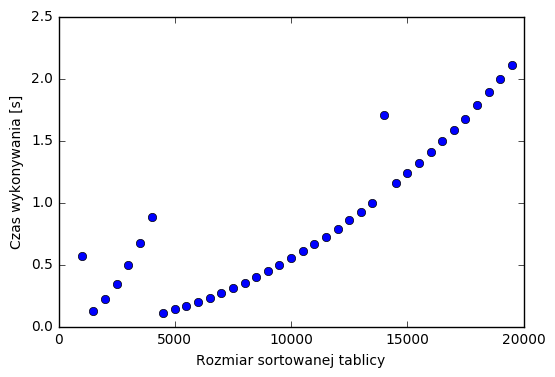

,Data size,Running time,Data ratio,Time ratio
0,2500.0,0.348119,NaN,NaN
1,5000.0,0.139083,2.0,0.399526
2,10000.0,0.558524,2.0,4.015772
3,20000.0,2.224016,2.0,3.981951
4,40000.0,8.898608,2.0,4.001144


In [3]:
apply_pessimistic = fn.partial(apply_quicksort, 'p', 10)

data_sizes = np.arange(1000, 20000, 500)
running_times = apply_pessimistic(data_sizes)
plot_times(data_sizes, running_times)

data_sizes2 = np.exp2(np.arange(5)) * 2500
running_times2 = apply_pessimistic(data_sizes2)
display_ratios(data_sizes2, running_times2)

Sądząc po wynikach, podwojenie rozmiaru danych powoduje czterokrotny wzrost czasu wykonywania. Zależność ta nie zachodzi dla względnie małych zestawów danych, zapewne dlatego, że wtedy część algorytmu, która nie zależy od danych, jest bardziej znacząca.

## Przypadek optymistyczny

W optymistycznym przypadku, sortowanie szybkie ma złożoność czasową $\Theta(n\ lg\ n)$. Jest to przypadek, gdy na każdym kroku sortowania za element osiowy (`pivot`) wybrana zostaje mediana przedziału i rekurencyjne wywołania algorytmu operują na podprzedziałach dwukrotnie krótszych lub prawie dwukrotnie, gdy długość jest nieparzysta.

Głebokość rekursji wynosi w takim przypadku $lg_2\ n$, przy czym na każdym poziomie głębokości przetworzonych zostaje $n$ elementów, a zatem ostatecznie liczba operacji zależy liniowologarytmicznie od rozmiaru sortowanego zestawu danych. Złożoność pamięciowa algorytmu zależy od głębokości rekursji, gdyż każde wywołanie wymaga zarezerwowania pewnej stałej ilości pamięci, i jest logarytmiczna.

W programie nie mamy opcji spreparowania danych do przypadku optymistycznego. Okazało się to trudniejsze niż samo sortowanie i jeżeli nasze przewidywania są trafne, wyniki nie będą różnić się charakterem od przedstawionego poniżej przypadku średniego.

## Przypadek średni

W średnim przypadku algorytm `quicksort` ma złożoność liniowologarytmiczną, podobnie jak w przypadku optymistycznym. Liczba operacji do wykonania jest zwykle relatywnie niewielka, czego skutkiem jest częste wykorzystanie tego algorytmu.

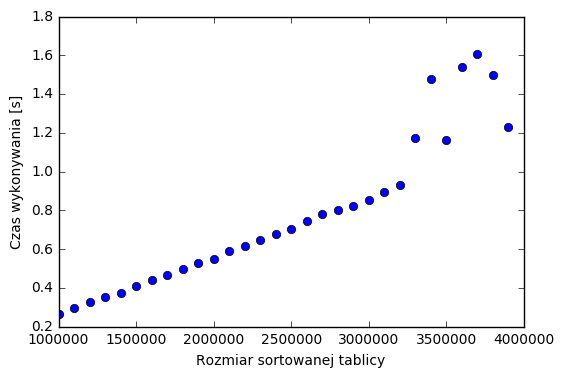

,Data size,Running time,Data ratio,Time ratio
0,1000000.0,0.267178,NaN,NaN
1,2000000.0,0.559268,2.0,2.093246
2,4000000.0,1.158979,2.0,2.072313
3,8000000.0,2.462841,2.0,2.125010
4,16000000.0,5.313126,2.0,2.157316


In [4]:
apply_average = fn.partial(apply_quicksort, 'r', 10)

data_sizes = np.arange(1000000, 4000000, 100000)
running_times = apply_average(data_sizes)
plot_times(data_sizes, running_times)

data_sizes2 = np.exp2(np.arange(5)) * 1000000
running_times2 = apply_average(data_sizes2)
display_ratios(data_sizes2, running_times2)

Jak widać czas zmienia się odrobinę szybciej niż liniowo względem rozmiaru danych. Tak właśnie wygląda złożoność liniowologarytmiczna i dlatego algorytmy o takiej charakterystyce są pożądane w praktyce.

Kwestią, na którą warto zwrócić uwagę, jest to jak szybkość działania algorytmu się zmienia, gdy w zestawie danych pojawia się dużo równych sobie elementów. Ustalenie, iż elementy równe elementowi osiowemu trafiają do jednego z podprzedziałów, które są rekurencyjnie sortowane, może sprawić, iż liczba operacji do wykonania wzrośnie wraz ze spadkiem liczby klas elementów. W szczególności jeżeli wszystkie elementy są sobie równe, to będziemy mieć do czynienia z przypadkiem pesymistycznym, gdyż $n - 1$ elementów trafi do prawego lub lewego podprzedziału.

Usunięcie tej cechy wymaga szczególnego traktowania elementów równych elementowi osiowemu. Jednym pomysłem może być umieszczanie ich na zmianę w lewym lub prawym podprzedziale. Alternatywnie można w trakcie dokonywania podziału umieścić wszystkie te elementy jeden po drugim obok elementu osiowego i rekurencyjnie dzielić tylko podprzedziały na lewo i na prawo od nich, ignorując je zupełnie, gdyż są już na swoim miejscu. Rozwiązanie to nadaje algorytmowi ciekawą cechę, iż jeżeli w zestawie danych jest $k$ klas elementów, to operacja podziału zostanie wykonana najwyżej $k$ razy. Jest to ogromnie korzystne, gdy $k$ jest małe, lecz odbywa się kosztem bardziej złożonej funkcji podziału. W wykonanym programie użyty został wariant wolniejszy. Poniżej zaprezentowano wyniki programu dla $k = 2$.

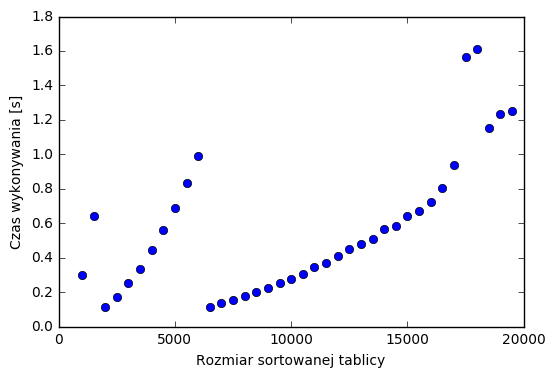

,Data size,Running time,Data ratio,Time ratio
0,2500.0,0.202926,NaN,NaN
1,5000.0,0.835189,2.0,4.115736
2,10000.0,0.327231,2.0,0.391805
3,20000.0,1.315393,2.0,4.019765
4,40000.0,5.347267,2.0,4.065147


In [5]:
data_sizes = np.arange(1000, 20000, 500)
running_times = apply_average(data_sizes, 2)
plot_times(data_sizes, running_times)

data_sizes2 = np.exp2(np.arange(5)) * 2500
running_times2 = apply_average(data_sizes2, 2)
display_ratios(data_sizes2, running_times2)

Nie licząc jednej anomalii, czas rośnie czterokrotnie, gdy rozmiar danych rośnie dwukrotnie. Złożoność jest zatem kwadratowa, tak jak w przypadku pesymistycznym i jak zostało to przewidziane.